In [1]:
import os
import re

import numpy as np
import pandas as pd
import moviepy.editor as mpy
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from sys import getsizeof
%matplotlib inline

In [2]:
def is_valid(filePath):
    try:
        test = io.imread(filePath)
        return test
    except:
        return False

In [3]:
fontSize = 48
font = ImageFont.truetype("/share/PI/rbaltman/alavertu/dataViewerVideoGenerator/data/resources/Hack-Bold.ttf", fontSize)

In [4]:
targetDir = "/scratch/PI/rbaltman/alavertu/screenomeCorpus/dataVideoTrial/LA04/LA04_Android_1"
outVideoName = "/share/PI/rbaltman/alavertu/dataViewerVideoGenerator/data/LA04Video.mp4"
os.chdir(targetDir)

In [5]:
fileList = os.listdir()

In [6]:
test = fileList[:100]

In [7]:
timeStamp = [int(re.search(r'(20[0-9]{12})',x).group(1)) for x in test]

In [8]:
timeStamp[0]

20170406193455

In [16]:
outFrame = pd.DataFrame({'fileName':test, 'timeStamp':timeStamp})

In [17]:
outFrame = outFrame.sort_values('timeStamp')

In [238]:
def findFirstNonCorrupt(fileList):
    i = 0
    trial = is_valid(fileList[i])
    if trial is not False:
        return(i)
    else:
        while(trial is False):
            i += 1
            trial = is_valid(fileList[i])
    return(i)

In [241]:
frame = Image.open(outFrame['fileName'][findFirstNonCorrupt(outFrame['fileName'])]).size
print(frame)

(1152, 1776)


In [231]:
frame = img.size
x_loc = frame[0]//2
y_loc = frame[1] - (frame[1]//4)

In [232]:
img = img.resize(frame)

In [233]:
trial3 = ImageDraw.Draw(img)

In [234]:
boxSize = trial3.textsize(outFrame['fileName'][30],font=font)
x_pos = x_loc - boxSize[0]//2
y_pos = y_loc - boxSize[1]//2

In [235]:
trial3.rectangle([x_pos-5, y_pos-5,
                  x_pos + boxSize[0] + 5, y_pos + boxSize[1] + 5], fill=(0,0,0))

In [236]:
trial3.text((x_pos, y_pos),outFrame['fileName'][30],(255,255,255),font=font)

In [316]:
# class imgDirGenerator(object):
def imgDirGenerator(dirPath):  
#     def __init__(, dirPath):
    fileList = os.listdir(dirPath)
    timeStamp = [int(re.search(r'(20[0-9]{12})',x).group(1)) for x in fileList]
    outFrame = pd.DataFrame({'fileName':fileList, 'timeStamp':timeStamp})
    outFrame = outFrame.sort_values('timeStamp')
    orderedFiles = outFrame['fileName'].tolist()
    startIndex = findFirstNonCorrupt(outFrame['fileName'])
    frame = Image.open(outFrame['fileName'][startIndex]).size
    x_loc = frame[0]//2
    y_loc = frame[1] - (frame[1]//4)

    for i in range(startIndex, len(orderedFiles)):
        
        img = Image.open(orderedFiles[i])
        try:
            img = img.resize(frame)
        except:
            continue
        tempDraw = ImageDraw.Draw(img)
        boxSize = tempDraw.textsize(orderedFiles[i],font=font)
        x_pos = x_loc - boxSize[0]//2
        y_pos = y_loc - boxSize[1]//2
        tempDraw.rectangle([x_pos-5, y_pos-5,
                  x_pos + boxSize[0] + 5, y_pos + boxSize[1] + 5], 
                           fill=(0,0,0))
        tempDraw.text((x_pos, y_pos),orderedFiles[i],(255,255,255),font=font)
        yield(np.array(img))

In [317]:
testGen = imgDirGenerator(targetDir)

In [318]:
testList = []
for i, x in enumerate(testGen):
    testList.append(x)

In [319]:
getsizeof(testList)

13008

In [320]:
len(testList)

1533

In [ ]:
# Custom ImageSequenceClip that can handle generators
class ImageSequenceClip(VideoClip):
    """
    
    A VideoClip made from a series of images.
    
    Parameters
    -----------
    sequence
      Can be one of these:
      - The name of a folder (containing only pictures). The pictures
        will be considered in alphanumerical order.
      - A list of names of image files. In this case you can choose to
        load the pictures in memory pictures 
      - A list of Numpy arrays representing images. In this last case,
        masks are not supported currently.
    fps
      Number of picture frames to read per second. Instead, you can provide
      the duration of each image with durations (see below)
    durations
      List of the duration of each picture.
    with_mask
      Should the alpha layer of PNG images be considered as a mask ?
    ismask
      Will this sequence of pictures be used as an animated mask.
    Notes
    ------
    If your sequence is made of image files, the only image kept in 
    
    """


    def __init__(self, sequence, fps=None, durations=None, with_mask=True,
                 ismask=False, load_images=False):

        # CODE WRITTEN AS IT CAME, MAY BE IMPROVED IN THE FUTURE

        if (fps is None) and (durations is None):
            raise ValueError("Please provide either 'fps' or 'durations'.")
        VideoClip.__init__(self, ismask=ismask)

        # Parse the data

        fromfiles = True

        if isinstance(sequence, list):
            if isinstance(sequence[0], str):
                if load_images:
                    sequence = [imread(f) for f in sequence]
                    fromfiles = False
                else:
                    fromfiles= True
            else:
                # sequence is already a list of numpy arrays
                fromfiles = False
        else:
            # sequence is a folder name, make it a list of files:
            fromfiles = True
            sequence = sorted([os.path.join(sequence, f)
                        for f in os.listdir(sequence)])


        #check that all the images are of the same size
        if isinstance(sequence[0], str):
           size = imread(sequence[0]).shape
        else:
           size = sequence[0].shape

        for image in sequence:
            image1=image
            if isinstance(image, str):
               image1=imread(image)
            if size != image1.shape:
               raise Exception("Moviepy: ImageSequenceClip requires all images to be the same size")


        self.fps = fps
        if fps is not None:
            durations = [1.0/fps for image in sequence]
            self.images_starts = [1.0*i/fps-np.finfo(np.float32).eps for i in range(len(sequence))]
        else:
            self.images_starts = [0]+list(np.cumsum(durations))
        self.durations = durations
        self.duration = sum(durations)
        self.end = self.duration
        self.sequence = sequence
        
        def find_image_index(t):
            return max([i for i in range(len(self.sequence))
                              if self.images_starts[i]<=t])

        if fromfiles:

            self.lastindex = None
            self.lastimage = None

            def make_frame(t):
            
                index = find_image_index(t)

                if index != self.lastindex:
                    self.lastimage = imread(self.sequence[index])[:,:,:3] 
                    self.lastindex = index
                
                return self.lastimage

            if with_mask and (imread(self.sequence[0]).shape[2]==4):

                self.mask = VideoClip(ismask=True)
                self.mask.lastindex = None
                self.mask.lastimage = None

                def mask_make_frame(t):
            
                    index = find_image_index(t)
                    if index != self.mask.lastindex:
                        frame = imread(self.sequence[index])[:,:,3]
                        self.mask.lastimage = frame.astype(float)/255
                        self.mask.lastindex = index

                    return self.mask.lastimage

                self.mask.make_frame = mask_make_frame
                self.mask.size = mask_make_frame(0).shape[:2][::-1]


        else:

            def make_frame(t):
            
                index = find_image_index(t)
                return self.sequence[index][:,:,:3]

            if with_mask and (self.sequence[0].shape[2]==4):

                self.mask = VideoClip(ismask=True)

                def mask_make_frame(t):
                    index = find_image_index(t)
                    return 1.0*self.sequence[index][:,:,3]/255

                self.mask.make_frame = mask_make_frame
                self.mask.size = mask_make_frame(0).shape[:2][::-1]
        
            
        self.make_frame = make_frame
self.size = make_frame(0).shape[:2][::-1]

In [321]:
clip = mpy.ImageSequenceClip(testList, fps=10)

In [322]:
clip.write_videofile(outVideoName, audio=False)

[MoviePy] >>>> Building video /share/PI/rbaltman/alavertu/dataViewerVideoGenerator/data/LA04Video.mp4
[MoviePy] Writing video /share/PI/rbaltman/alavertu/dataViewerVideoGenerator/data/LA04Video.mp4


100%|██████████| 1533/1533 [04:36<00:00,  5.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /share/PI/rbaltman/alavertu/dataViewerVideoGenerator/data/LA04Video.mp4 



<Figure size 600x1500 with 0 Axes>

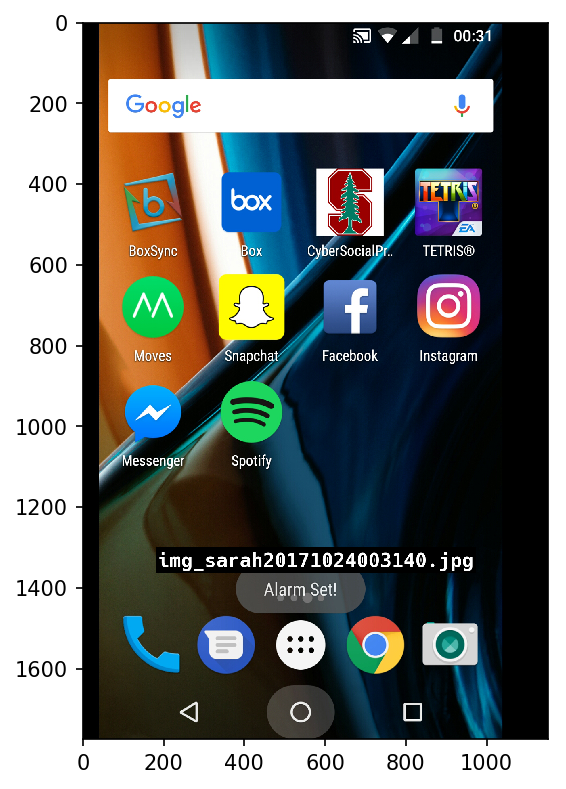

In [237]:
plt.figure(figsize=(4, 10), dpi=150)
plt.imshow(np.array(img))